In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.integrate as integrate
from scipy.stats import gamma
import math
from scipy.stats.distributions import norm
from scipy import stats
from pyDOE import *
%matplotlib inline

In [3]:
def ADRSource(Lx, Nx, Source, omega, v, kappa):
    #Solves the diffusion equation with Generalized Source
    A = sparse.dia_matrix((Nx,Nx),dtype="complex")
    dx = Lx/Nx
    i2dx2 = 1.0/(dx*dx)
    #fill diagonal of A
    A.setdiag(2*i2dx2*omega + np.sign(v)*v/dx)
    #fill off diagonals of A
    A.setdiag(-i2dx2*omega[1:Nx] + 
              0.5*(1-np.sign(v[1:Nx]))*v[1:Nx]/dx,1)
    A.setdiag(-i2dx2*omega[0:(Nx-1)] - 
              0.5*(np.sign(v[0:(Nx-1)])+1)*v[0:(Nx-1)]/dx,-1)
    #solve A x = Source
    Solution = linalg.spsolve(A,Source)
    Q = integrate.trapz(Solution*kappa,dx=dx)
    return Solution, Q

In [4]:
def run_calc(Lx, Nx, rho, Source, omega, v, 
             kappa, dt, steps,
             tmin,tmax,xmin,xmax, IC):
    dx = Lx/Nx
    assert IC.size==Nx
    irho = 1/rho
    dt2 = dt/2
    idx2 = 1/dx**2
    solution = np.zeros((Nx+2,steps+1))
    solution[1:Nx+1,0] = 1.0*IC #copy IC
    xs = np.linspace(-dx/2,Lx+dx/2,Nx+2)
    Q = 0
    for step in range(steps):
        #predictor
        pred = solution[:,step]*1.0
        
        pred[1:Nx+1] = (pred[1:Nx+1]-irho*kappa*dt2*pred[1:Nx+1]**4 +
                        irho*dt2*Source +
                        irho*dt2*omega*idx2*(pred[2:Nx+2]**4 - 2*pred[1:Nx+1]**4 + pred[0:Nx]**4))
        
        #corrector
        solution[1:Nx+1,step+1] = (solution[1:Nx+1,step]-irho*kappa*dt*pred[1:Nx+1]**4 + 
                                   irho*dt*Source +
                                   irho*dt*omega*idx2 * (pred[2:Nx+2]**4 - 2*pred[1:Nx+1]**4 + pred[0:Nx]**4))
        if ((step+1)*dt >= tmin) and ((step+1)*dt <= tmax):
            Q += np.sum(dt*solution[1:Nx+1,step][(xs[1:Nx+1]>=xmin)*(xs[1:Nx+1]<=xmax)]*
                        kappa[(xs[1:Nx+1]>=xmin)*(xs[1:Nx+1]<=xmax)]*dx)
    return solution,Q,xs

0.0001
20000
0.0870897107306


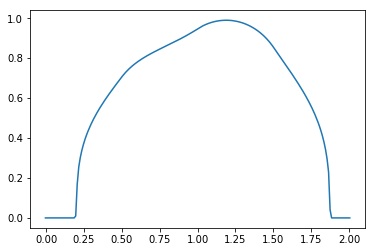

In [5]:
#set up simple advection problem
Lx = 2
Nx = 200
dx = Lx/Nx
dt = dx**2
print(dt)
tfinal = 2
numsteps = math.ceil(tfinal/dt)
xs = np.linspace(dx/2,Lx-dx/2,Nx)
Source_func = lambda x, q:  (x>0.25*Lx)*(x<0.75*Lx)*q
kappa_func = lambda x, kappal, kappah: kappah + (kappal-kappah)*(x>0.5*Lx)*(x<0.75*Lx)
print(numsteps)
IC = np.zeros(Nx)
IC[Nx//4:3*Nx//4] = 1*0
source = IC*0
source[Nx//4:3*Nx//4] = 10

omega_nom = .1
v_nom = 0.0
kappal_nom = 0.1
kappal_var = 8.511570e-6
kappah_nom = 2
kappah_var = 0.002778142
q_nom = 1
q_var = 7.062353e-4
rho = 1.0

sol,Q,xs2 = run_calc(Lx, Nx, rho, Source_func(xs,1), omega_nom, v_nom, 
                 kappa_func(xs,kappal_nom, kappah_nom), dt, numsteps, 1.8,tfinal,1.5,1.9,IC)
print(Q)
plt.plot(xs2,sol[:,numsteps])

In [6]:
def run_adjoint_calc(Lx, Nx, rho, Source, omega, v, kappa, dt, steps,tmin,tmax,xmin,xmax, IC, forward):
    dx = Lx/Nx
    assert IC.size==Nx
    dt2 = dt/2
    irho = 1/rho
    solution = np.zeros((Nx+2,steps+1))
    solution[1:Nx+1,steps] = 1.0*IC #copy IC
    xs = np.linspace(-dx/2,Lx+dx/2,Nx+2)
    Q = 0
    ks = kappa*(xs[1:Nx+1]>=xmin)*(xs[1:Nx+1]<=xmax)
    for step in range(steps-1,-1,-1):
        #predictor
        pred = solution[:,step+1]*1.0
        pred[1:Nx+1] = (pred[1:Nx+1]*(1- irho*4*kappa*dt2*forward[1:Nx+1,step]**3) + 
                        irho*dt2*ks*((step+1)*dt >= tmin)*((step+1)*dt <= tmax) +
                        irho*4*dt2*omega/(dx**2)*forward[1:Nx+1,step]**3 * (pred[2:Nx+2]-2*pred[1:Nx+1] + pred[0:Nx]))  
                        
        
        #corrector
        solution[1:Nx+1,step] = (solution[1:Nx+1,step+1]-irho*4*kappa*dt*pred[1:Nx+1]*forward[1:Nx+1,step]**3 + 
                                 irho*dt*ks*((step+1)*dt >= tmin)*((step+1)*dt <= tmax)+
                                 irho*4*dt*omega/(dx**2)*forward[1:Nx+1,step]**3 * (pred[2:Nx+2]-2*pred[1:Nx+1] + pred[0:Nx])) 
    return solution,xs

In [7]:
sol_adj,xs2 = run_adjoint_calc(Lx, Nx,rho, Source_func(xs,1), omega_nom, v_nom, 
                 kappa_func(xs,kappal_nom, kappah_nom), dt, numsteps, 1.8,tfinal,1.5,1.9,IC*0, sol)

output = np.vstack([xs2,sol[:,numsteps], sol_adj[:,round(1.8/dt)]]).transpose()
np.savetxt('nonlindr_foradj.csv', output, delimiter=',')

In [8]:
sens_adj = np.zeros(5)
sens_for = np.zeros(5)
#rho sens
delta = 1.0e-6
sol_pert,Q_v,xs2 = run_calc(Lx, Nx, rho+delta,Source_func(xs,1), omega_nom, v_nom, 
                 kappa_func(xs,kappal_nom, kappah_nom), dt, numsteps,1.8,tfinal,1.5,1.9,IC)
sens_for[0] = (Q_v-Q)/delta

dudx = np.zeros((Nx+2,numsteps+1))
dudx[:,0:(numsteps)] = (sol[:,1:(numsteps+1)] - sol[:,0:(numsteps)])/(dt)
#dudx[Nx-1] = (0-sol[Nx-2])/(2*dx)
#dudx[0,:] = (sol[0,:]-0)/(dx)
sens_adj[0] = np.sum(-dudx*sol_adj*dx*dt)
print(sens_for[0],sens_adj[0])

-0.0994797332704 -0.0994842935224


In [15]:
#omega sens
delta = 1.0e-6
sol_pert,Q_v,xs2 = run_calc(Lx, Nx,rho, Source_func(xs,1), omega_nom+delta, v_nom, 
                 kappa_func(xs,kappal_nom, kappah_nom), dt, numsteps, 1.8,tfinal,1.5,1.9,IC)
sens_for[1] = (Q_v-Q)/delta

dudx2 = np.zeros((Nx+2,numsteps+1))
dx = Lx/Nx
dudx2[1:(Nx+1),:] = (sol[0:Nx,:]**4 - 2*sol[1:(Nx+1),:]**4 + sol[2:(Nx+2),:]**4)/(dx**2)
sens_adj[1] = np.sum(dudx2*sol_adj*dx*dt)
print(sens_for[1],sens_adj[1])

0.288975471816 0.288993704224


In [16]:
low_area = lambda x: (x>0.5*Lx)*(x<0.75*Lx)
low_area_abs = lambda x: (x>1.5)*(x<1.9)*(x>0.5*Lx)*(x<0.75*Lx)
delta = 1e-6
sens_adj[2] = np.sum(dx*(sol[low_area_abs(xs2),:])*dt)
sens_adj[2] += np.sum(-sol[low_area(xs2),:]**4*sol_adj[low_area(xs2),:]*dt*dx)
sol_pert,Q_v,xs2 = run_calc(Lx, Nx,rho, Source_func(xs,1), omega_nom, v_nom, 
                 kappa_func(xs,kappal_nom+delta, kappah_nom), dt, numsteps, 1.8,tfinal,1.5,1.9,IC)
sens_for[2] = (Q_v-Q)/delta
print(sens_for[2],sens_adj[2])

-0.0302243683414 -0.0302261859764


In [17]:
delta = 1e-6
high_area_abs = lambda x: (x>1.5)*(x<1.9)*(x>1.75*Lx)+(x>1.5)*(x<1.9)*(x<1.5*Lx)
high_area = lambda x: (x<0.5*Lx)+(x>0.75*Lx)
ts = np.linspace(0,tfinal,numsteps+1)
intime = lambda t: (t>=1.8)*(t<=tfinal)*1+0
sens_adj[3] = np.sum(dx*(sol[high_area_abs(xs2),:])*intime(ts)*dt)
sens_adj[3] += np.sum(-sol[high_area(xs2),:]**4*sol_adj[high_area(xs2),:]*dt*dx)
sol_pert,Q_v,xs2 = run_calc(Lx, Nx, rho, Source_func(xs,1), omega_nom, v_nom, 
                 kappa_func(xs,kappal_nom, kappah_nom+delta), dt, numsteps, 1.8,tfinal,1.5,1.9,IC)
sens_for[3] = (Q_v-Q)/delta
print(sens_for[3],sens_adj[3])

0.0321559995853 0.0321576786136


In [18]:
sens_adj[4] = np.sum(dx*sol_adj[(xs2>0.25*Lx)*(xs2<0.75*Lx),:]*dt)
sol_pert,Q_v,xs2 = run_calc(Lx, Nx, rho,Source_func(xs,1+delta), omega_nom, v_nom, 
                 kappa_func(xs,kappal_nom, kappah_nom), dt, numsteps, 1.8,tfinal,1.5,1.9,IC)
sens_for[4] = (Q_v-Q)/delta
print(sens_for[4],sens_adj[4])

0.096382224285 0.0963874959062


In [19]:
output = np.vstack([sens_for,sens_adj,np.abs(sens_for-sens_adj)/np.abs(sens_for)/1e-5]).transpose()

import tabulate
print(tabulate.tabulate(output, tablefmt="latex", floatfmt=".6f"))



\begin{tabular}{rrr}
\hline
 -0.099480 & -0.099484 & 4.584102 \\
  0.288975 &  0.288994 & 6.309327 \\
 -0.030224 & -0.030226 & 6.013806 \\
  0.032156 &  0.032158 & 5.221509 \\
  0.096382 &  0.096387 & 5.469495 \\
\hline
\end{tabular}


In [20]:
dt

0.0001

# Comparison for Reliability

In [39]:
means = [rho, omega_nom, kappal_nom, kappah_nom, q_nom]
varmat = np.zeros((5,5))
#fill in diagonal
corrmat = np.ones((5,5))
corrmat[0,:] = (1,.1,-0.05,0,0)
corrmat[1,:] = (.1,1,-.4,.3,.5)
corrmat[2,:] = (-0.05,-.4,1,.2,0)
corrmat[3,:] = (0,.3,0.2,1,-.1)
corrmat[4,:] = (0,.5,0,-.1,1)
print(corrmat-corrmat.transpose())
print(corrmat)


samps = 10**5
test = norm.cdf(np.random.multivariate_normal(np.zeros(5), corrmat, samps))

def gen_samps(samps,test):
    #rho will have v_nom = 1 v_var = .1 which makes alpha = 10 beta = 10 or theta = 1/10
    vsamps = gamma.ppf(test[:,0], a = 100, scale = 1/100)
    print(np.mean(vsamps), np.var(vsamps), np.std(vsamps))
    #plt.hist(vsamps)

    #omega will have  omega_nom = .1, var = .1 which makes alpha = 100 beta = 5, theta = 1/5
    omegasamps = gamma.ppf(test[:,1], a = 100, scale = 1/2000)
    print(np.mean(omegasamps), np.var(omegasamps), np.std(omegasamps))
    #plt.hist(omegasamps)

    #kappa_l will have kappa_l = 0.1 var = (0.01)^2 this makes alpha = 100 and theta = 1/1000
    kappalsamps = gamma.ppf(test[:,2], a = 100, scale = 1/1000)
    print(np.mean(kappalsamps), np.var(kappalsamps), np.std(kappalsamps))
    #plt.hist(kappalsamps)

    #kappa_h will have kappa_h = 2 var = .04 this makes alpha = 100 and theta = 1/50
    kappahsamps = gamma.ppf(test[:,3], a = 100, scale = 1/50)
    print(np.mean(kappahsamps), np.var(kappahsamps), np.std(kappahsamps))
    #plt.hist(kappahsamps)

    #q will have q = 1 var = 0.01 this makes alpha = 100 and theta = 1/100
    qsamps = gamma.ppf(test[:,4], a = 100, scale = 1/100)
    print(np.mean(qsamps), np.var(qsamps),np.std(qsamps))
    #plt.hist(qsamps)
    
    return vsamps,omegasamps,kappalsamps,kappahsamps,qsamps
vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test)

var_list = [vsamps,omegasamps,kappalsamps,kappahsamps,qsamps]
cormat_emp = np.zeros((5,5))
tmp = np.vstack((var_list[0],var_list[1],var_list[2],var_list[3],var_list[4]))
cormat_emp = np.cov(tmp)
sens = np.array([-0.0994797332704,0.288975471816,-0.0302243683414,0.0321559995853,0.096382224285])
print(cormat_emp, np.dot(sens,np.dot(cormat_emp,sens)))

print(run_calc(Lx, Nx, np.mean(vsamps), Source_func(xs,np.mean(qsamps)), np.mean(omegasamps), v_nom, 
                 kappa_func(xs,np.mean(kappalsamps), np.mean(kappahsamps)), dt, numsteps, 1.8,tfinal,1.5,1.9,IC))

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 1.    0.1  -0.05  0.    0.  ]
 [ 0.1   1.   -0.4   0.3   0.5 ]
 [-0.05 -0.4   1.    0.2   0.  ]
 [ 0.    0.3   0.2   1.   -0.1 ]
 [ 0.    0.5   0.   -0.1   1.  ]]
1.00001693935 0.0100031768293 0.100015882885
0.0499927203002 2.49876065312e-05 0.00499876049948
0.100031118721 9.69302700409e-05 0.00984531716304
1.9996229583 0.0397916644138 0.19947848108
1.00024477553 0.0100322241685 0.100160991252
[[  1.00032769e-02   5.37073889e-05  -1.53571225e-05   1.24279561e-04
    5.77761255e-05]
 [  5.37073889e-05   2.49878564e-05  -5.13536095e-06   3.00205474e-04
    2.49782578e-04]
 [ -1.53571225e-05  -5.13536095e-06   9.69312394e-05   1.03506063e-04
    8.53208079e-09]
 [  1.24279561e-04   3.00205474e-04   1.03506063e-04   3.97920623e-02
   -1.97166107e-03]
 [  5.77761255e-05   2.49782578e-04   8.53208079e-09  -1.97166107e-03
    1.00323245e-02]] 0.000237587673053
(array([[ 0.,  

In [80]:
outputs=np.zeros(samps)
for i in range(samps):
    sol,Q,xs2 = run_calc(Lx, Nx, vsamps[i], Source_func(xs,qsamps[i]), omegasamps[i], v_nom, 
                 kappa_func(xs,kappalsamps[i], kappahsamps[i]), dt, numsteps, 1.8,tfinal,1.5,1.9,IC)
    outputs[i] = Q


In [81]:
print(np.var(outputs),outputs,vsamps)

np.savetxt("nonlinear_ref_adr.csv", outputs, delimiter=",")

0.000168977961208 [ 0.0758376   0.05247246  0.06567038  0.06491645  0.06578588  0.07347046
  0.04496058  0.07238792  0.09889938  0.05998711  0.05742438  0.08154488
  0.05784084  0.05742587  0.07618354  0.06773856  0.08037387  0.06752153
  0.04557107  0.07288127  0.07079158  0.06217861  0.07677953  0.07696757
  0.06038116  0.06425697  0.08494746  0.04650765  0.06950902  0.0485939
  0.06843103  0.07964242  0.05386176  0.05683926  0.06497688  0.06228932
  0.06892968  0.05448631  0.05225762  0.08255353  0.07118859  0.08683272
  0.09157414  0.08877509  0.06868606  0.06797714  0.06951059  0.08477477
  0.06545807  0.09370803  0.05892454  0.06534413  0.08727347  0.07476078
  0.06529256  0.07612197  0.07615071  0.06587469  0.08261837  0.05369392
  0.07759026  0.07438838  0.04875654  0.07837396  0.05113254  0.09423639
  0.06673006  0.09971209  0.08991427  0.07527576  0.07886121  0.06218317
  0.08198277  0.04992019  0.07723439  0.0844493   0.05566213  0.06721833
  0.07029319  0.09455974  0.068641

(array([ 1.,  1.,  1.,  0.,  1.,  2.,  1.,  0.,  2.,  1.]),
 array([ 0.04625416,  0.05003977,  0.05382538,  0.05761099,  0.0613966 ,
         0.06518221,  0.06896782,  0.07275343,  0.07653904,  0.08032465,
         0.08411026]),
 <a list of 10 Patch objects>)

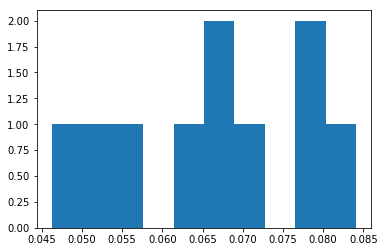

In [78]:
plt.hist(outputs)

In [20]:
#lhd will have the values in 0 to 1
samps =10**5
lhd = lhs(5, samples=samps)
#now i need to turn these into samples from N(0,Corrmat)
#do cholesky fact
chol = np.linalg.cholesky(corrmat)

lhs_unif = np.zeros((samps,5))
for i in range(samps):
    lhs_unif[i,:] = np.dot(chol,norm.ppf(lhd[i,:]))
test_lhs = norm.cdf(lhs_unif)

vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test_lhs)

0.999999898498 0.00999977488355 0.0999988744114
0.0499999980193 2.49993373348e-05 0.00499993373304
0.100000508724 0.000100159540409 0.0100079738413
1.99998915736 0.0399396088876 0.19984896519
1.00000240279 0.010005562802 0.100027810143


In [21]:
QLHS = np.zeros(samps)
outputs_LHS=np.zeros(samps)
for i in range(samps):
    sol,QLHS[i],xs2 = run_calc(Lx, Nx, vsamps[i], Source_func(xs,qsamps[i]), omegasamps[i], v_nom, 
                 kappa_func(xs,kappalsamps[i], kappahsamps[i]), dt, numsteps, 1.8,tfinal,1.5,1.9,IC)
    outputs_LHS[i] = QLHS[i]


plt.hist(QLHS)
plt.show()
print(np.mean(QLHS),stats.scoreatpercentile(QLHS,95),stats.scoreatpercentile(QLHS,5),np.std(QLHS), 
      stats.kurtosis(QLHS), stats.skew(QLHS))
#print(np.mean(Qs),stats.scoreatpercentile(Qs,95) ,stats.scoreatpercentile(Qs,5),np.std(Qs), stats.kurtosis(Qs), stats.skew(Qs))

np.savetxt("nonlinear_ref_adr_LHS.csv", outputs_LHS, delimiter=",")



KeyboardInterrupt: 

In [22]:
np.savetxt("nonlinear_ref_adr_LHS.csv", outputs_LHS, delimiter=",")



In [38]:
print(np.mean((np.random.rand(samps)>0.01)*(0.101005-0.000501256) + (0.000501256)),
      np.std((np.random.rand(samps)>0.01)*(0.101005-0.000501256) + (0.000501256)))

0.100001972635 0.00990049113847
